# Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/Users/josuealemansanchez/Desktop/eco-tools')
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
from data_helper import *
import warnings
warnings.filterwarnings('ignore')

## Get Data

In [2]:
#search for point if needed
point = pc.search_by_point('*gbsf*elec*demand*kbtu*')
point

['GBSF_Electricity_Demand_kBtu']

### Set Data Parameters

In [3]:
start = '2016-01-01'
end = '*'
interval = '1h'
calculation = 'summary'

### Ensure only one point is passed

Grabbing WebIDs ...
WebID collection complete!
10:37:48: Sending API request... Chunk 1 of 1
10:37:49: Response recieved for 1 tags! (1.42)


Column                      |Percent NaN | Rows NaN/Total Rows
--------------------------------------------------------------
GBSF_Electricity_Demand_kBtu|  0.07 %    | 23/31518


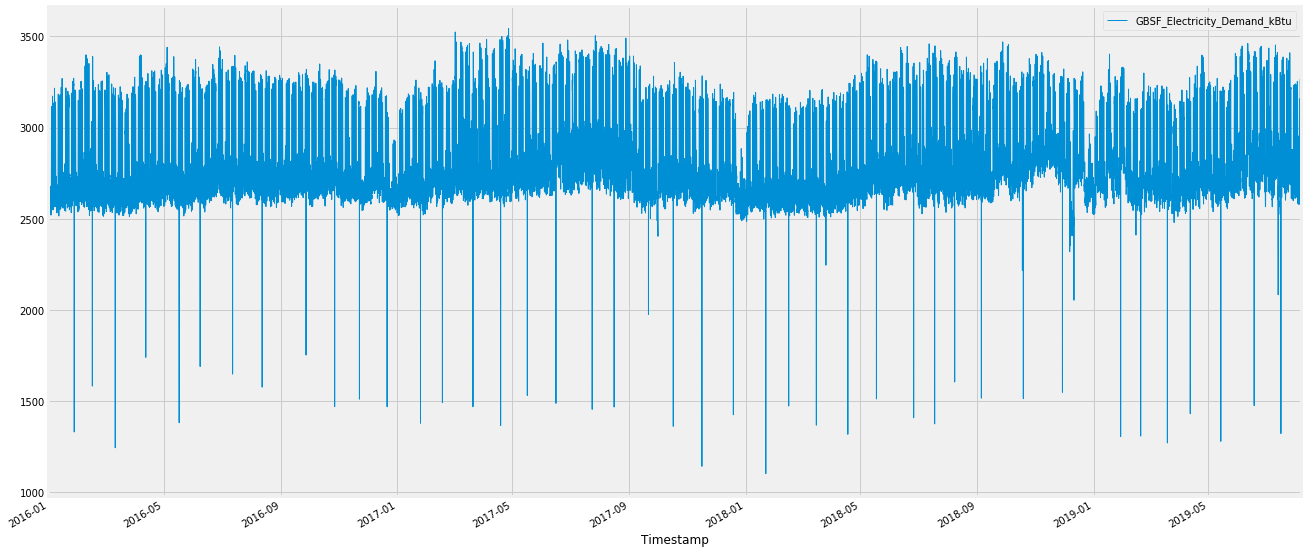

In [4]:
df = pc.get_stream_by_point(point, start = start, end = end, interval = interval, calculation = calculation)
print_report(df)

## Generate Model

In [5]:
kwargs = {
    #the point to be evaluated
    'point': point[0],
    
    #Determining the amount of data that will be used to train the model 0 < training_percent < 1.0
    'training_percent': 0.7,

    #clean_type can be either 'value' or 'iqr'
    'clean_type': 'value',

    #if clean is 'value' then pass the value you want the cut to be
    # if you want IQR then determine the IQR to cut at
    'threshold': 2500,

    #can be either 'LSTM' or 'Random Forest'
    'model_type': 'LSTM',
    
    #determine if model should train on residuals or the normal data
    'train_on_residuals': True
}

In [6]:
check_kwargs(kwargs)

'Good values!'

In [7]:
def create_model(df, kwargs):
    training, testing = split_data(df[kwargs['point']], split = kwargs['training_percent'])
    
    return training, testing

In [8]:
training, testing = create_model(df, kwargs)


In [9]:
training.head()

Timestamp
2016-01-01 00:00:00    2550.633333
2016-01-01 01:00:00    2535.975618
2016-01-01 02:00:00    2538.258333
2016-01-01 03:00:00    2548.635795
2016-01-01 04:00:00    2556.464644
Name: GBSF_Electricity_Demand_kBtu, dtype: float64

lower_bound: 1829.304989 and upper_bound: 3846.268959


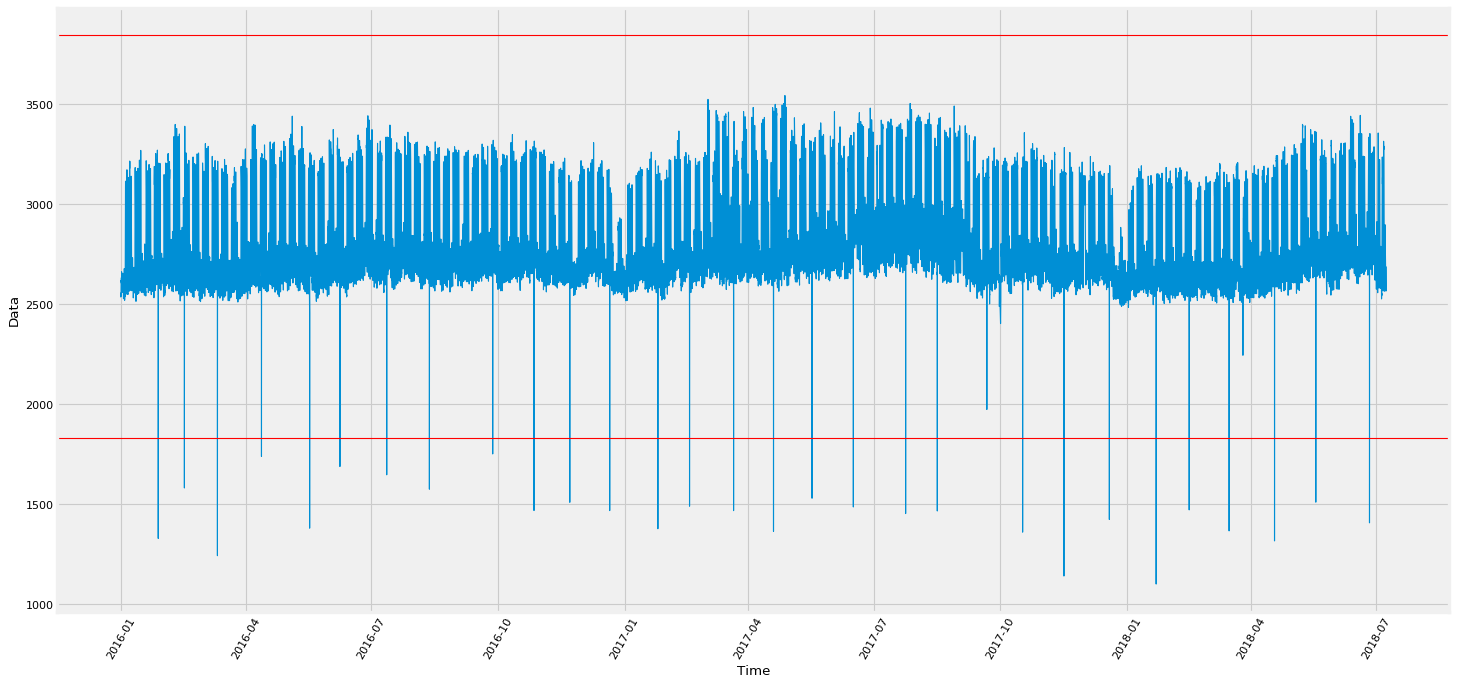

In [11]:
training1 = clean_data(training, threshold=2.1, type_clean = 'iqr')